# Random Forest Regression

In [10]:
# reoder variables to work on train or test dataset
predict_for_submission = True
predict_for_submission = False

In [23]:
from import_man import *


%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

Loading dataset:

In [12]:
df = pd.read_csv('dataset/preprocessed_train_PCA.csv')

if predict_for_submission:
    df_test = pd.read_csv('dataset/preprocessed_test_PCA.csv')

print('Dataset has been loaded correctly')

Dataset has been loaded correctly


In [13]:
print('(examples,columns)')
df.shape

(examples,columns)


(433958, 45)

selecting useful features:

In [14]:
df = df.drop(['NumberOfCustomers'], axis=1)
print('Since we do not have NumberOfCustomers attribute in the test set, we drop it.')

Since we do not have NumberOfCustomers attribute in the test set, we drop it.


In [15]:
print('Categorical attributes are dropped because we consider for the analysis the "One Hot Encoding" version.')
df = df.drop(['Unnamed: 0','StoreType','AssortmentType','D_DayOfweek'], axis=1)

Categorical attributes are dropped because we consider for the analysis the "One Hot Encoding" version.


### Attributes kept:

In [16]:
df.head().T

,0,1,2,3,4
StoreID,1000,1000,1000,1000,1000
Date,01/03/2016,02/03/2016,04/03/2016,05/03/2016,07/03/2016
IsHoliday,0,0,0,0,0
HasPromotions,0,0,0,0,1
NearestCompetitor,326,326,326,326,326
Region,7,7,7,7,7
NumberOfSales,5676,8111,8300,7154,10110
Region_AreaKM2,9643,9643,9643,9643,9643
Region_GDP,17130,17130,17130,17130,17130
Region_PopulationK,2770,2770,2770,2770,2770


The attributes identified by "px" where x goes from 1 to 12 are the components obtained performing PCA on several attributes. 
You can check the whole PCA notebook looking at "3.4_Prepr_train_PCA".

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

Loading train and test set:

In [18]:
import modify_dataset as md

if predict_for_submission:
    train = df
    test = df_test
else:
    test_months = (3, 4)
    test_year = 2017

    train = md.get_fake_train(df, test_months, test_year)
    test = md.get_fake_test(df, test_months, test_year)

print('df.shape    ', df.shape)
print('train.shape ', train.shape)
print('test.shape  ', test.shape)

y_train = train['NumberOfSales']

df.shape     (433958, 40)
train.shape  (396420, 40)
test.shape   (37538, 40)


# Feature selection on the train set:

In [24]:
features = list(train.columns.values)
features.remove('NumberOfSales')
features.remove('StoreID')
features.remove('Date')
print("features")

pprint(sorted(features))

features
['AssortmentType_General',
 'AssortmentType_WithFishDept',
 'AssortmentType_WithNFDept',
 'CloudCover',
 'D_Day',
 'D_DayOfWeek_cos',
 'D_DayOfWeek_sin',
 'D_DayOfYear',
 'D_Month',
 'D_Year',
 'HasPromotions',
 'IsHoliday',
 'MeanCustomers',
 'MeanRegionCustomers',
 'MeanRegionSales',
 'MeanStoreSales',
 'NearestCompetitor',
 'Region',
 'Region_AreaKM2',
 'Region_GDP',
 'Region_PopulationK',
 'StoreType_HyperMarket',
 'StoreType_ShoppingCenter',
 'StoreType_StandardMarket',
 'StoreType_SuperMarket',
 'p1',
 'p10',
 'p11',
 'p12',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9']


In [25]:
train.shape

(396420, 40)

In [26]:
train[features].head().T

,0,1,2,3,4
IsHoliday,0.000000,0.000000,0.000000,0.000000,0.000000
HasPromotions,0.000000,0.000000,0.000000,0.000000,1.000000
NearestCompetitor,326.000000,326.000000,326.000000,326.000000,326.000000
Region,7.000000,7.000000,7.000000,7.000000,7.000000
Region_AreaKM2,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000
Region_GDP,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000
Region_PopulationK,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000
CloudCover,8.000000,8.000000,8.000000,6.000000,0.000000
D_Day,1.000000,2.000000,4.000000,5.000000,7.000000
D_DayOfYear,61.000000,62.000000,64.000000,65.000000,67.000000


# Random Forest parameters tuning

n_estimators analysis: 

In [13]:
params = range(1, 101, 10)  #50,201,50

In [14]:
from sklearn.ensemble import RandomForestRegressor
scores, tst_scr = validation_curve(RandomForestRegressor(), train[features][:20000],\
                                   y_train[:20000], 'n_estimators', params, \
                                   cv=5, scoring='r2',n_jobs=-1, verbose=2)

[CV] n_estimators=1 ..................................................
[CV] n_estimators=11 .................................................
[CV] n_estimators=21 .................................................
[CV] n_estimators=31 .................................................
[CV] n_estimators=41 .................................................
[CV] n_estimators=51 .................................................
[CV] n_estimators=61 .................................................
[CV] n_estimators=71 .................................................
[CV] ................................... n_estimators=1, total=   0.6s
[CV] n_estimators=81 .................................................
[CV] .................................. n_estimators=11, total=   5.8s
[CV] n_estimators=91 .................................................
[CV] .................................. n_estimators=21, total=  11.0s
[CV] n_estimators=1 ..................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:  2.5min remaining:  2.5min


[CV] .................................. n_estimators=71, total= 1.8min
[CV] n_estimators=31 .................................................
[CV] .................................. n_estimators=11, total=  10.8s
[CV] n_estimators=41 .................................................
[CV] .................................. n_estimators=61, total= 1.0min
[CV] n_estimators=51 .................................................
[CV] .................................. n_estimators=91, total= 1.8min
[CV] n_estimators=61 .................................................
[CV] .................................. n_estimators=21, total=  20.2s
[CV] n_estimators=71 .................................................
[CV] .................................. n_estimators=31, total=  27.3s
[CV] n_estimators=81 .................................................
[CV] .................................. n_estimators=71, total= 1.2min
[CV] n_estimators=91 .................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.0min finished


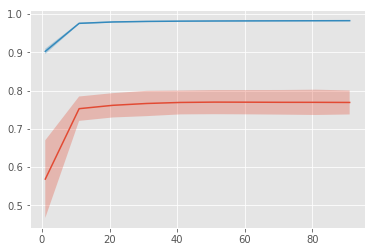

In [15]:
scores_mean = scores.mean(axis=1)
scores_std = scores.std(axis=1)
tst_scr_mean = tst_scr.mean(axis=1)
tst_scr_std = tst_scr.std(axis=1)
plt.plot(params, tst_scr_mean)
plt.fill_between(params, tst_scr_mean + tst_scr_std, tst_scr_mean - tst_scr_std, alpha=0.3)
plt.plot(params, scores_mean)
plt.fill_between(params, scores_mean + scores_std, scores_mean - scores_std, alpha=0.3)

As we can see in the graph, from 40 estimators on the performance curve is stable, so we set n_estimators = 40. 

##### 

max_features analysis:

In [16]:
params = range(1, 35,2)

In [17]:
from sklearn.ensemble import RandomForestRegressor
scores, tst_scr = validation_curve(RandomForestRegressor(n_estimators=10), train[features][:20000], \
                                   y_train[:20000], 'max_features', params, \
                                   cv=3, scoring='r2',n_jobs=-1, verbose=2)

[CV] max_features=1 ..................................................
[CV] max_features=3 ..................................................
[CV] max_features=5 ..................................................
[CV] max_features=7 ..................................................
[CV] max_features=9 ..................................................
[CV] max_features=11 .................................................
[CV] max_features=13 .................................................
[CV] max_features=15 .................................................
[CV] ................................... max_features=1, total=   0.4s
[CV] max_features=17 .................................................
[CV] ................................... max_features=3, total=   0.6s
[CV] max_features=19 .................................................
[CV] ................................... max_features=5, total=   0.8s
[CV] max_features=21 .................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  26 out of  51 | elapsed:    7.9s remaining:    7.6s


[CV] .................................. max_features=19, total=   2.4s
[CV] max_features=1 ..................................................
[CV] ................................... max_features=1, total=   0.4s
[CV] max_features=3 ..................................................
[CV] .................................. max_features=21, total=   2.7s
[CV] .................................. max_features=23, total=   2.5s
[CV] max_features=5 ..................................................
[CV] max_features=7 ..................................................
[CV] ................................... max_features=3, total=   0.6s
[CV] max_features=9 ..................................................
[CV] .................................. max_features=25, total=   3.0s
[CV] max_features=11 .................................................
[CV] ................................... max_features=5, total=   0.9s
[CV] max_features=13 .................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:   18.9s finished


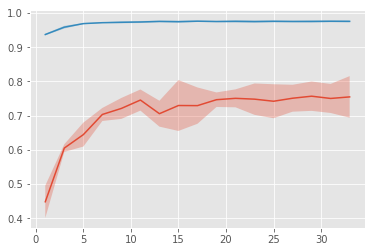

In [18]:
scores_mean = scores.mean(axis=1)
scores_std = scores.std(axis=1)
tst_scr_mean = tst_scr.mean(axis=1)
tst_scr_std = tst_scr.std(axis=1)
plt.plot(params, tst_scr_mean)
plt.fill_between(params, tst_scr_mean + tst_scr_std, tst_scr_mean - tst_scr_std, alpha=0.3)
plt.plot(params, scores_mean)
plt.fill_between(params, scores_mean + scores_std, scores_mean - scores_std, alpha=0.3)

As we can see in the chart above, it seems that more than 20 features can ensure the best performances.

max_depth analysis:

In [19]:
params = range(5, 101, 5)

In [20]:
from sklearn.ensemble import RandomForestRegressor
scores, tst_scr = validation_curve(RandomForestRegressor(n_estimators=100), train[features][:20000], \
                                   y_train[:20000], 'max_depth', params, \
                                   cv=3, scoring='r2',n_jobs=-1, verbose=2)

[CV] max_depth=5 .....................................................
[CV] max_depth=10 ....................................................
[CV] max_depth=15 ....................................................
[CV] max_depth=20 ....................................................
[CV] max_depth=25 ....................................................
[CV] max_depth=30 ....................................................
[CV] max_depth=35 ....................................................
[CV] max_depth=40 ....................................................
[CV] ...................................... max_depth=5, total=  17.9s
[CV] max_depth=45 ....................................................
[CV] ..................................... max_depth=10, total=  35.5s
[CV] max_depth=50 ....................................................
[CV] ..................................... max_depth=15, total=  51.1s
[CV] max_depth=55 ....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  30 out of  60 | elapsed:  4.0min remaining:  4.0min


[CV] ..................................... max_depth=55, total=  55.0s
[CV] max_depth=95 ....................................................
[CV] ..................................... max_depth=60, total=  53.8s
[CV] max_depth=100 ...................................................
[CV] ..................................... max_depth=65, total=  55.7s
[CV] max_depth=5 .....................................................
[CV] ..................................... max_depth=70, total=  55.8s
[CV] max_depth=10 ....................................................
[CV] ..................................... max_depth=75, total=  56.2s
[CV] max_depth=15 ....................................................
[CV] ...................................... max_depth=5, total=  18.8s
[CV] max_depth=20 ....................................................
[CV] ..................................... max_depth=80, total=  56.2s
[CV] max_depth=25 ....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.7min finished


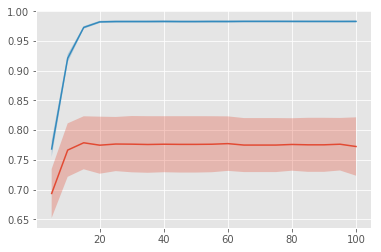

In [21]:
scores_mean = scores.mean(axis=1)
scores_std = scores.std(axis=1)
tst_scr_mean = tst_scr.mean(axis=1)
tst_scr_std = tst_scr.std(axis=1)
plt.plot(params, tst_scr_mean)
plt.fill_between(params, tst_scr_mean + tst_scr_std, tst_scr_mean - tst_scr_std, alpha=0.3)
plt.plot(params, scores_mean)
plt.fill_between(params, scores_mean + scores_std, scores_mean - scores_std, alpha=0.3)

The graph above show how a suitable value for max_depth is 20, indeed even increasing it, the performance are stable.

# Model Building 

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
model1 = RandomForestRegressor(n_estimators=50, max_depth=20, n_jobs=-1, verbose=2)

In [31]:

model1.fit(train[features], train['NumberOfSales'])

building tree 1 of 50building tree 2 of 50building tree 3 of 50

building tree 4 of 50

building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.0min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.6min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=2, warm_start=False)

Which are the most relevant features?

In [32]:
idx = model1.feature_importances_.argsort()[::-1]

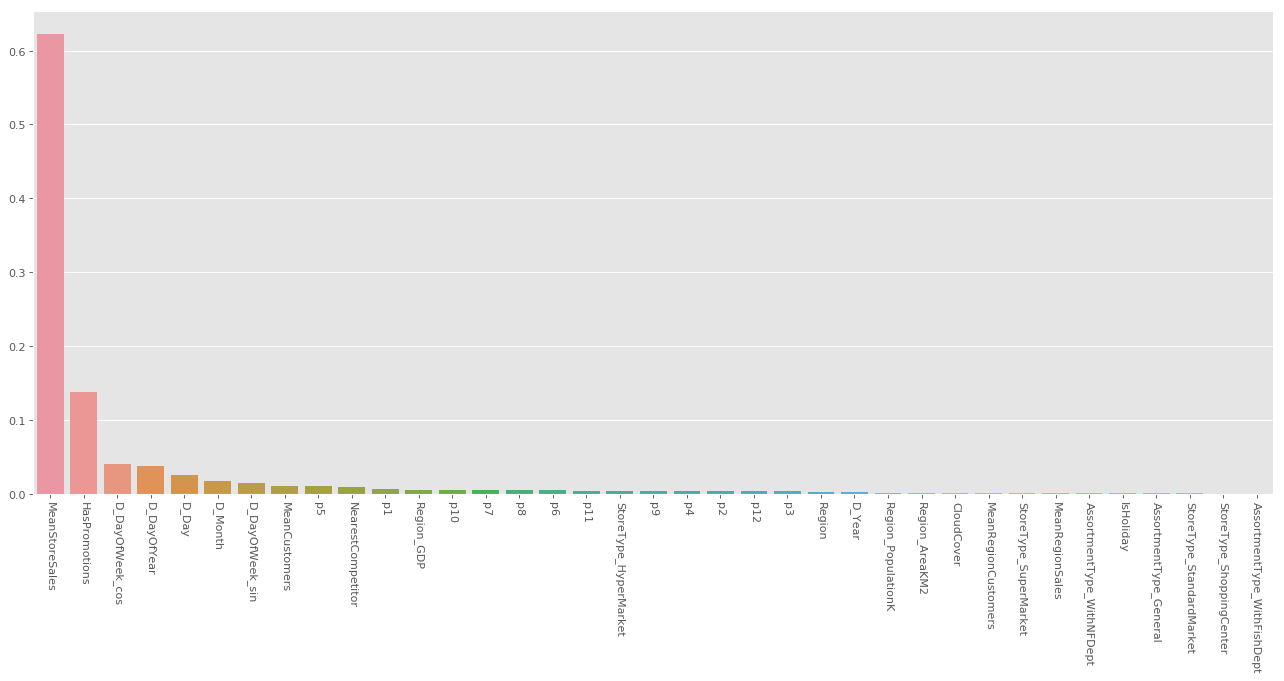

In [33]:
ax = sns.barplot(x=df[features].columns[idx], y=model1.feature_importances_[idx])
_ = plt.setp(ax.get_xticklabels(), rotation=-90)

# Predict

In [34]:
test['_NumberOfSales'] = model1.predict(test[features])

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


In [36]:
train['_NumberOfSales'] = model1.predict(train[features])

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.3s finished


# Estimating error through BIP function

In [35]:
if not predict_for_submission:
    from BIP import get_BIP_error
    error1 = get_BIP_error(test)

BIP total error: 0.039154274077734155


In [37]:
if not predict_for_submission:
    from BIP import get_BIP_error
    error1 = get_BIP_error(train)

BIP total error: 0.015150337673198143


## Writing to file

In [ ]:
if predict_for_submission:
    test.to_csv('./dataset/submission_53_RFR_on_prep.csv', index=False)
else:
    mm = 'm{}{}'.format(test_months[0],test_months[1])
    test.to_csv('./dataset/test_'+mm+'_53_RFR_on_prep.csv', index=False)

# Estimating error through R2 function

In [29]:
# calculationg R2

# calculate RSS
df_RSS = test
print(df_RSS.shape)

df_RSS['sqrd_diff'] = df_RSS.apply(lambda x: (x['NumberOfSales'] - x['_NumberOfSales'])**2, axis=1)

RSS = df_RSS['sqrd_diff'].sum()
print('RSS:', RSS)
df_RSS.head()

(36911, 45)
RSS: 27390619345.05524


/home/nyxgear/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,StoreID,Date,IsHoliday,HasPromotions,NearestCompetitor,Region,NumberOfSales,Region_AreaKM2,Region_GDP,Region_PopulationK,...,p5,p6,p7,p8,p9,p10,p11,p12,_NumberOfSales,sqrd_diff
548,1000,01/01/2018,0,0,326,7,8540,9643,17130,2770,...,-0.002012,0.002307,0.001049,-0.001226,0.000372,0.000095,0.000836,-0.000170,10208.159259,2.782755e+06
549,1000,02/01/2018,0,0,326,7,10364,9643,17130,2770,...,-0.002070,0.002708,-0.000669,-0.001426,-0.000215,-0.000540,0.000367,-0.000163,6004.900000,1.900175e+07
550,1000,03/01/2018,0,0,326,7,4676,9643,17130,2770,...,-0.002125,0.003129,-0.000895,-0.001529,-0.000557,0.000031,-0.000107,-0.000037,4079.066667,3.563294e+05
551,1000,05/01/2018,0,0,326,7,6267,9643,17130,2770,...,0.002572,-0.000628,-0.000278,-0.001221,0.000540,0.000499,-0.000087,-0.000236,7445.791362,1.389549e+06
552,1000,06/01/2018,0,0,326,7,5953,9643,17130,2770,...,0.000616,0.003896,0.000200,-0.001384,-0.000087,-0.000091,0.000085,0.000273,7577.743277,2.639791e+06


In [30]:
# calculate TSS

df_TSS = test
NS_mean = df_TSS['NumberOfSales'].mean()
print('NS_mean', NS_mean)

df_TSS['sqrd_diff'] = df_TSS.apply(lambda x:  (x['_NumberOfSales'] - NS_mean)**2, axis=1)
TSS = df_TSS['sqrd_diff'].sum()
print('TSS:', TSS)
df_TSS.head()

NS_mean 4761.829833924846
TSS: 166431512680.66556


/home/nyxgear/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,StoreID,Date,IsHoliday,HasPromotions,NearestCompetitor,Region,NumberOfSales,Region_AreaKM2,Region_GDP,Region_PopulationK,...,p5,p6,p7,p8,p9,p10,p11,p12,_NumberOfSales,sqrd_diff
548,1000,01/01/2018,0,0,326,7,8540,9643,17130,2770,...,-0.002012,0.002307,0.001049,-0.001226,0.000372,0.000095,0.000836,-0.000170,10208.159259,2.966250e+07
549,1000,02/01/2018,0,0,326,7,10364,9643,17130,2770,...,-0.002070,0.002708,-0.000669,-0.001426,-0.000215,-0.000540,0.000367,-0.000163,6004.900000,1.545223e+06
550,1000,03/01/2018,0,0,326,7,4676,9643,17130,2770,...,-0.002125,0.003129,-0.000895,-0.001529,-0.000557,0.000031,-0.000107,-0.000037,4079.066667,4.661655e+05
551,1000,05/01/2018,0,0,326,7,6267,9643,17130,2770,...,0.002572,-0.000628,-0.000278,-0.001221,0.000540,0.000499,-0.000087,-0.000236,7445.791362,7.203649e+06
552,1000,06/01/2018,0,0,326,7,5953,9643,17130,2770,...,0.000616,0.003896,0.000200,-0.001384,-0.000087,-0.000091,0.000085,0.000273,7577.743277,7.929369e+06


In [31]:
# calculate R2
print("RSS:", RSS, "   TSS:", TSS)

R2 = 1 - (RSS / TSS)
print('R_2:', R2)


RSS: 27390619345.05524    TSS: 166431512680.66556
R_2: 0.8354240798278989


## Sample of predicted results

In [5]:
import matplotlib.pyplot as plt

y_pred_subset = test['_NumberOfSales'][500:600]
x_coordinate = [ 1 * i for i in range(len(y_pred_subset)) ]
plt.plot(x_coordinate,y_pred_subset)
plt.show()

NameError: name 'test' is not defined

## Sample of real results

In [ ]:
#REAL
import matplotlib.pyplot as plt

y_train_subset = test['NumberOfSales'][500:600]
x_coordinate = [ 1 * i for i in range(len(y_train_subset)) ]
plt.plot(x_coordinate,y_train_subset)
plt.show()

## Real-Predicted

In [ ]:
plt.plot(x_coordinate,y_train_subset)
plt.plot(x_coordinate,y_pred_subset)

plt.legend(['Predicted', 'Real'], loc='upper left')
plt.show()